In [1]:
import numpy as np
import renom as rm
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import renom.utility.distributor.distributor as distr
import renom.cuda as cu
import matplotlib.pyplot as plt

In [2]:
# First, we gather the normal MNIST Data set and set up the data as per usual

mnist = fetch_mldata('MNIST original', data_home='dataset')
X = mnist.data.astype(np.float64)
X /= np.amax(X)
X = X.reshape(-1, 1, 28, 28)
Y = mnist.target
Y = LabelBinarizer().fit_transform(Y).astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

In [3]:
# We construct the model in two variants, one that can uses layer normalization and one that does not
# The one utilizing layer normalization has more units to train, as gain and bias are trainable parameters

class MNist(rm.Model):
    def __init__(self, use_norm = False):
        super(MNist,self).__init__()
        self.l1 = rm.Conv2d(channel=32,filter=5,padding=2)
        self.a1 = rm.Relu()
        self.l2 = rm.MaxPool2d(filter=2,stride=2)
        if use_norm:
            self.l22 = rm.LayerNormalization()
        self.l3 = rm.Conv2d(channel=64,filter=5,padding=2)
        self.l4 = rm.MaxPool2d(filter=2,stride=2)
        self.l5 = rm.Dense(1024)
        self._norm = use_norm
        self.l6 = rm.Dense(10)

    def forward(self, x):
        ret = self.l1(x)
        ret = self.l2(ret)
        ret = self.a1(ret)
        if self._norm:
            ret = self.l22(ret)
        ret = self.l3(ret)
        ret = self.l4(ret)
        ret = self.a1(ret)
        ret = ret.reshape(ret.shape[0],-1)
        ret = self.l5(ret)
        ret = self.a1(ret)
        ret = self.l6(ret)
        return ret

In [4]:
# Set up hyperparameters

cu.set_cuda_active(True)
epochs = 40
opt = rm.Sgd(0.001)
batch_size = 100
train_distributor = distr.NdarrayDistributor(X_train,y_train)
# Since we are training one relatively large datasets, we construct another distributor for the test data,
# in order to avoid using too much memory and doing the test in batches.
test_distributor = distr.NdarrayDistributor(X_test,y_test)
normed_model = MNist(use_norm = True)
regular_model = MNist(use_norm = False)
batches = X_train.shape[0]

In [5]:
# Here we perform the training. For each epoch we first train the normalized model once and then the regular model.
def train_model(distributor, model, train = True):
    loss = 0
    for batch_x, batch_y in distributor.batch(batch_size):
        if train:
            with model.train():
                z = model(batch_x)
                l = rm.softmax_cross_entropy(z,batch_y)
            l.grad().update(opt)
        else:
            z = model(batch_x)
            l = rm.softmax_cross_entropy(z,batch_y)
        loss += l.as_ndarray()
    return loss/(len(distributor)//batch_size+1)
    

normed_loss = []
normed_test = []
regular_loss = []
regular_test = []

for e in range(epochs):
    normed_loss.append(train_model(train_distributor, normed_model, train = True))
    regular_loss.append(train_model(train_distributor, regular_model, train = True))
    print('Finished epoch #{:d} with normalized loss: {} and regular loss: {}'.format(e+1,normed_loss[-1],regular_loss[-1]))
    normed_test.append(train_model(test_distributor, normed_model, train = False))
    regular_test.append(train_model(test_distributor, regular_model, train = False))
    print('Normalized test loss of {} and regular test loss of {}'.format(normed_test[-1], regular_test[-1]))

Finished epoch #1 with normalized loss: [2.0689507] and regular loss: [2.2152472]
Normalized test loss of [1.7617888] and regular test loss of [2.031241]
Finished epoch #2 with normalized loss: [1.3467478] and regular loss: [1.3515643]
Normalized test loss of [0.96899015] and regular test loss of [0.70121676]
Finished epoch #3 with normalized loss: [0.7336107] and regular loss: [0.5041213]
Normalized test loss of [0.59468687] and regular test loss of [0.42198437]
Finished epoch #4 with normalized loss: [0.5072727] and regular loss: [0.35961178]
Normalized test loss of [0.44950163] and regular test loss of [0.34388423]
Finished epoch #5 with normalized loss: [0.4069981] and regular loss: [0.30225235]
Normalized test loss of [0.3877784] and regular test loss of [0.29898614]
Finished epoch #6 with normalized loss: [0.34914112] and regular loss: [0.2668628]
Normalized test loss of [0.3379719] and regular test loss of [0.2599951]
Finished epoch #7 with normalized loss: [0.310143] and regula

<IPython.core.display.Javascript object>


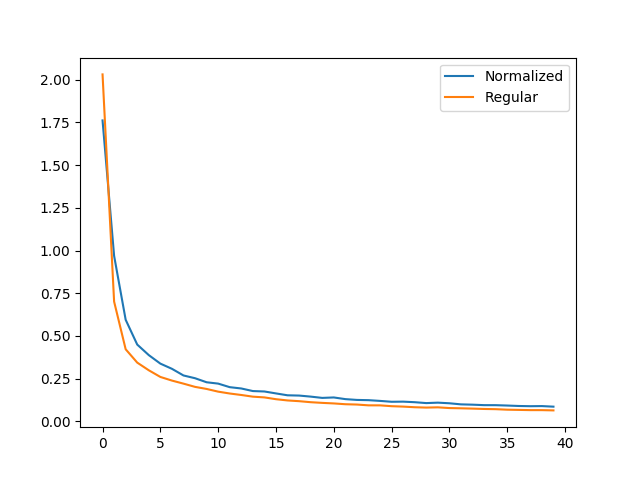

In [6]:
%matplotlib notebook

# Now we plot the data together to show the effect of normalization, nothing too fancy here.

plt.plot(range(epochs),normed_test, label="Normalized")
plt.plot(range(epochs),regular_test, label="Regular")
plt.legend()
plt.show()